# TP Final Vision por Computadora - Rodrigo Pazos

Este trabajo parte del siguiente dataset: [Lemon Quality Dataset](https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset). El objetivo es poder desarrollar un clasificador que logre diferenciar entre los limones de buena y mala calidad.

## Descargar dataset

In [ ]:
! pip install kaggle

In [4]:
! kaggle datasets download -d yusufemir/lemon-quality-dataset

100%|███████████████████████████████████████▉| 232M/233M [00:22<00:00, 10.3MB/s]
100%|████████████████████████████████████████| 233M/233M [00:22<00:00, 10.7MB/s]


In [6]:
! unzip lemon-quality-dataset.zip

Archive:  lemon-quality-dataset.zip
  inflating: lemon_dataset/.git/COMMIT_EDITMSG  
  inflating: lemon_dataset/.git/FETCH_HEAD  
  inflating: lemon_dataset/.git/HEAD  
  inflating: lemon_dataset/.git/config  
  inflating: lemon_dataset/.git/description  
  inflating: lemon_dataset/.git/hooks/applypatch-msg.sample  
  inflating: lemon_dataset/.git/hooks/commit-msg.sample  
  inflating: lemon_dataset/.git/hooks/fsmonitor-watchman.sample  
  inflating: lemon_dataset/.git/hooks/post-update.sample  
  inflating: lemon_dataset/.git/hooks/pre-applypatch.sample  
  inflating: lemon_dataset/.git/hooks/pre-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-merge-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-push.sample  
  inflating: lemon_dataset/.git/hooks/pre-rebase.sample  
  inflating: lemon_dataset/.git/hooks/pre-receive.sample  
  inflating: lemon_dataset/.git/hooks/prepare-commit-msg.sample  
  inflating: lemon_dataset/.git/hooks/push-to-checkout.sample  
  inflating:

In [14]:
! rm -rf lemon_dataset/.git

## Cargar dataset

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import pytorch_lightning as pl
from torchvision import datasets

ImportError: cannot import name 'CSVLogger' from 'pytorch_lightning.callbacks' (/home/rodrigo/miniconda3/envs/vision_computadora_II/lib/python3.9/site-packages/pytorch_lightning/callbacks/__init__.py)

En principio no es necesario aplicar ninguna transformacion para normalizar el tamaño de las imagenes, dado que de por si ya todas son de 300x300. Solo se usara transform para pasar las imagenes a tensores.

In [43]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

In [44]:
dataset = datasets.ImageFolder('lemon_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Class: bad_quality


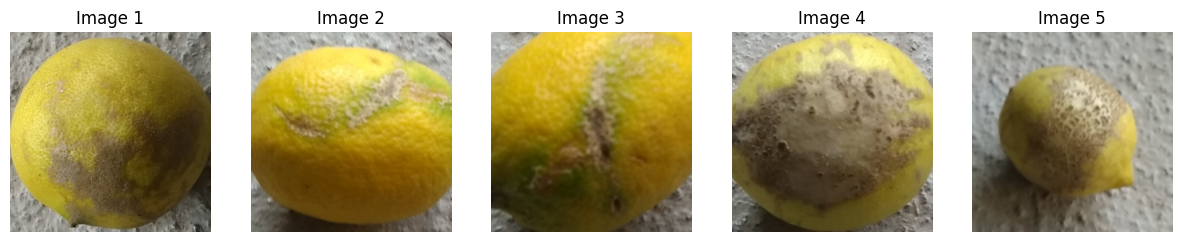

Class: empty_background


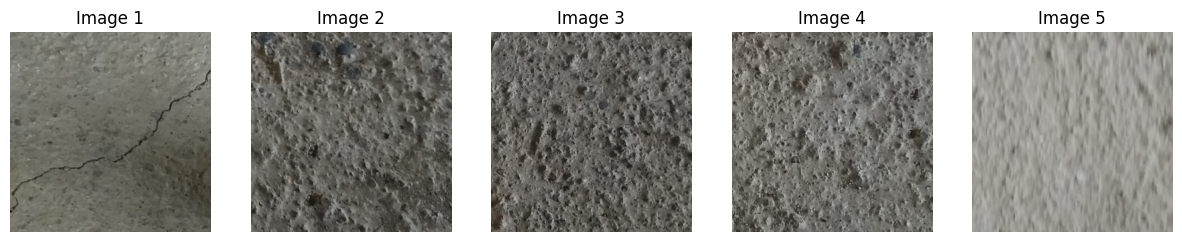

Class: good_quality


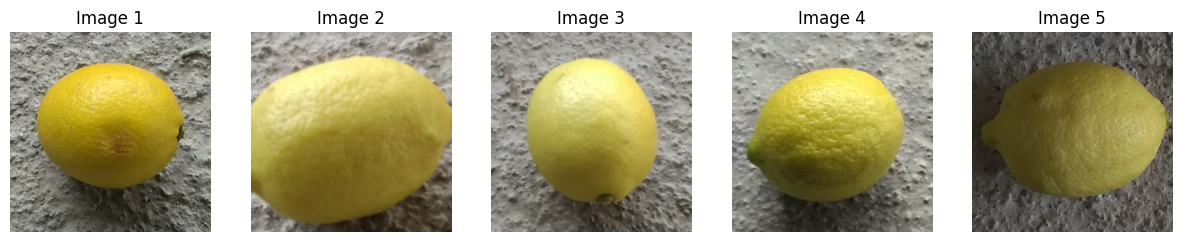

In [45]:
num_images_per_class = 5 
classes = dataset.classes

class_images = {cls: [] for cls in classes}

for images, labels in dataloader:
    class_name = classes[labels[0]]
    if len(class_images[class_name]) < num_images_per_class:
        class_images[class_name].append(images[0])

for class_name, images in class_images.items():
    print(f"Class: {class_name}")
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, image in enumerate(images):
        axs[i].imshow(transforms.ToPILImage()(image))
        axs[i].set_title(f"Image {i+1}")
        axs[i].axis('off')
    plt.show()

Se puede observar que el dataset fue cargado correctamente. Eventualmente habra que evaluar si esta forma de representar las imagenes es la mejor. Eso se puede ajustar mas adelante.

In [67]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 150 * 150, 64)  # Adjust input size as needed
        self.fc2 = nn.Linear(64, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log validation accuracy

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()
        self.log('test_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log test accuracy

In [68]:
# Get the number of classes
num_classes = len(dataset.classes)

# Define the proportions for train, validation, and test splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
total_samples = len(dataset)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Perform random splitting
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Define PyTorch Lightning DataModules for train, validation, and test
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=32):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Initialize PyTorch Lightning DataModule
data_module = CustomDataModule(train_dataset, val_dataset, test_dataset)

# Verify the sizes of the splits
print(f"Train set batch size: {len(data_module.train_dataloader())}")
print(f"Validation batch set size: {len(data_module.val_dataloader())}")
print(f"Test batch set size: {len(data_module.test_dataloader())}")

Train set batch size: 56
Validation batch set size: 12
Test batch set size: 12


In [69]:
trainer = pl.Trainer(max_epochs=10)

model = SimpleCNN(num_classes=len(dataset.classes))
trainer.fit(model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 448   
1 | pool      | MaxPool2d        | 0     
2 | fc1       | Linear           | 23.0 M
3 | fc2       | Linear           | 195   
4 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
92.163    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 56/56 [00:40<00:00,  1.37it/s, v_num=7, train_loss_step=0.168, val_loss_step=0.141, val_accuracy_step=0.926, val_loss_epoch=0.0766, val_accuracy_epoch=0.976, train_loss_epoch=0.0434]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:41<00:00,  1.36it/s, v_num=7, train_loss_step=0.168, val_loss_step=0.141, val_accuracy_step=0.926, val_loss_epoch=0.0766, val_accuracy_epoch=0.976, train_loss_epoch=0.0434]


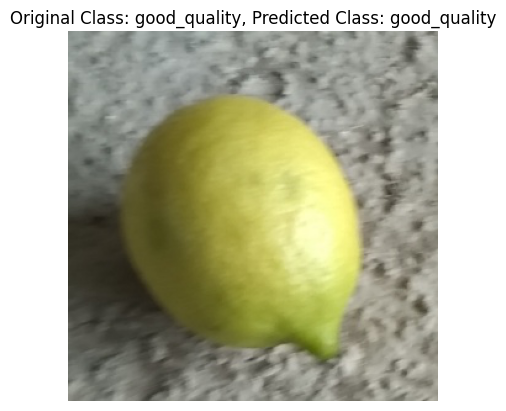

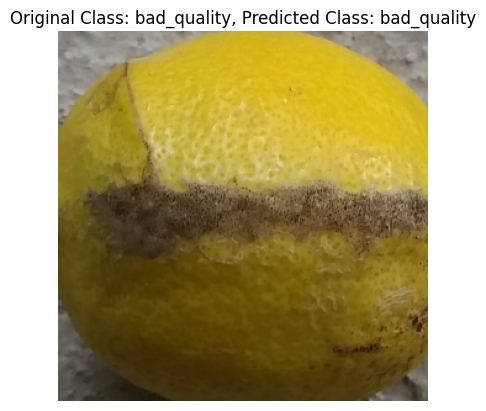

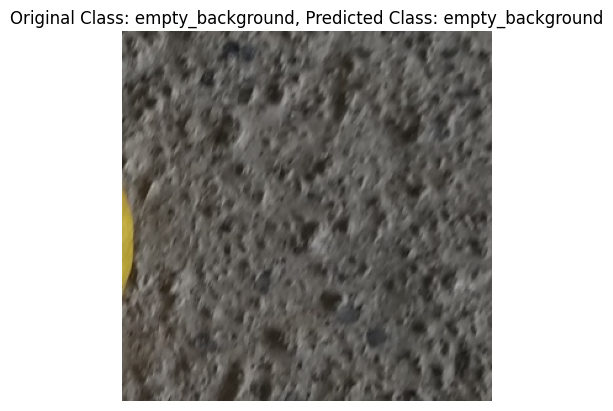

In [74]:
import matplotlib.pyplot as plt

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Define a dictionary to store one image per class
one_image_per_class = {}

# Iterate through the test DataLoader to select one image per class
with torch.no_grad():
    for image, label in test_dataloader:
        predicted = model(image)
        predicted_class = predicted.argmax(1).item()
        
        # If we haven't stored an image for this class yet, store it
        if predicted_class not in one_image_per_class:
            one_image_per_class[predicted_class] = (image, label)

# Display one image per class along with original and predicted labels
for class_index, (image, label) in one_image_per_class.items():
    original_class_label = dataset.classes[label.item()]
    predicted_class_label = dataset.classes[class_index]
    
    # Show the image, original label, and predicted label
    plt.figure()
    plt.title(f"Original Class: {original_class_label}, Predicted Class: {predicted_class_label}")
    plt.imshow(transforms.ToPILImage()(image[0]))
    plt.axis('off')
    plt.show()
